# Logistic Regression

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix



## Set up Classifier

### Load test data

In [ ]:
#load test data.
csv_file = 'yelp_labelled.txt'

#use pandas csv in order to organize our data more easily. 
#here we split into reviews and ratings, which are either 0(negative) or 1(positive)
data = pd.read_csv(csv_file, sep = '\t', names = ['Reviews', 'Rating'], header = None)

#load up our logistic regression model and tfidf transformer taken from scikit learn's linear_model tools
#we set C, the inverse regularization strength, 10 instead of the default 1. 
logistic = linear_model.LogisticRegression(C = 10)
tfidf_transformer = TfidfTransformer()

In [2]:
#test to see that the reviews and ratings are split correctly. 
data.head()

,Reviews,Rating
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Split data into ratings and review sets and Vectorize reviews

In [3]:
#Split data into ratings and review data sets
ratings = data['Rating']
reviews = data['Reviews']


In [4]:
#CountVectorizer is another sklearn tool
#  that allows us to transform our documents into feature vectors. 
#  features vectors 
count_vect = CountVectorizer()

x_train_counts = count_vect.fit_transform(reviews[0:][::2])
x_test_counts = count_vect.transform(reviews[1:][::2])
x_train_counts.shape
x_test_counts.shape


(500, 1363)

### Transform and Fit to model

In [5]:
#Use tf-idf weighting for training set.
#fit for the logisticregression model and for the data. 
X_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
logistic.fit(X_train_tfidf, ratings[0:][::2]) #ratings[:500])


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Compute Accuracy

In [6]:
#Take unused(test) data and transform using tfidf again.
#However this time we only use transform instead of fit transform
#  since we have already fit to the training set. 
X_test_tfidf = tfidf_transformer.transform(x_test_counts)

#Predict using the LogisticRegression predict feature. 
predicted = logistic.predict(X_test_tfidf)

#test accuracy of the predicted vs actual ratings. 
np.mean(predicted == ratings[1:][::2])

0.80200000000000005

In [7]:
#sklearning provides a pipeline class which streamlines the tokenization and transform steps shown above. 
clfpipe = pipeline.Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', logistic)])

clfpipe.fit(reviews[0:][::2], ratings[0:][::2])
predicted = clfpipe.predict(reviews[1:][::2])
np.mean(predicted == ratings[1:][::2])


0.80200000000000005

### K-fold Cross Validation

In [8]:
#k-fold cross validation test. K = 50 
k = 50
foldsize = reviews.size/k
frev = []
frat = []
checkstart = 0
checkend = foldsize
accuracies = []

for i in range(k):
    frev.append((reviews[checkstart:checkend]))
    frat.append((ratings[checkstart:checkend]))
    checkstart+=foldsize
    checkend+=foldsize

for i in range(k):
    temprev = []
    temprat = []
    for j in range(k):
        if j != i:
            temprev.extend(frev[j])
            temprat.extend(frat[j])
            
    clfpipe.fit(temprev, temprat)
    kfpredicted = clfpipe.predict(frev[i])
    accuracies.append(np.mean(kfpredicted == frat[i]))

kfresult = sum(accuracies)/len(accuracies)
print('Accuracy: ' + str(kfresult*100) + '%' )


Accuracy: 82.9%


### Make train/test sets

In [9]:
#Make train/test sets
train_data = reviews[0:][::2]
train_rate = ratings[0:][::2]
test_data = reviews[1:][::2]
test_rate = ratings[1:][::2]

test_reviews = test_data.values
test_scores = test_rate.values


In [10]:
probs = clfpipe.predict_proba(reviews[1:][::2])

## Visualizations
### Probability Distributions of Test Data

In [1]:
# Show examples of probability distribution
for i in range(10):
    print('{}\n\t Positive: {}%; Negative: {}%\n'.
          format(test_reviews[i], round(probs[i][1]*100, 2), round(probs[i][0]*100, 2)))

NameError: name 'test_reviews' is not defined

### Actual vs Classified Sentiment Distributions

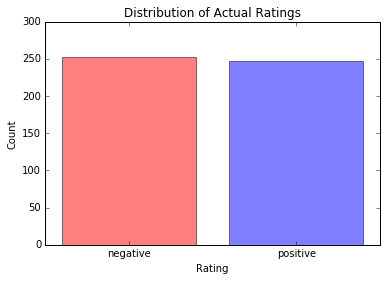

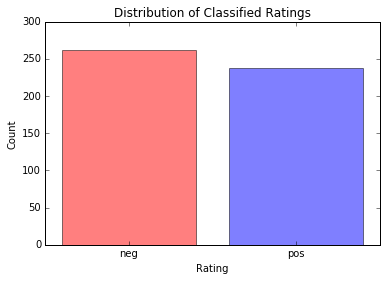

In [12]:
# Split test data by positive and negative sentiments
pos1, neg1, pos2, neg2 = 0, 0, 0, 0

for c in range(len(test_scores)):
    if test_scores[c] == 1:
        pos1 += 1
    else:
        neg1 += 1
    if predicted[c] == 1:
        pos2 += 1
    else:
        neg2 += 1

# Plot distribution of actual ratings vs distribution of classified ratings
plt.bar([1, 2], [neg1, pos1], align = 'center', color=['red', 'blue'], alpha = 0.5)
plt.xticks([1, 2], ['negative', 'positive'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Actual Ratings')

plt.show()

plt.bar([1, 2], [neg2, pos2], align = 'center', color=['red', 'blue'], alpha = 0.5)
plt.xticks([1, 2], ['neg', 'pos'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Classified Ratings')

plt.show()

### Test Data Confusion Matrix

Normalized confusion matrix
[[ 0.82  0.18]
 [ 0.22  0.78]]


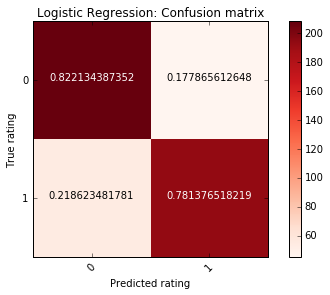

In [13]:
class_names = [0,1]

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True rating')
    plt.xlabel('Predicted rating')

# Compute confusion matrix
cnf_matrix = confusion_matrix(ratings[1:][::2], predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Logistic Regression: Confusion matrix')


plt.show()